### Student Details

Student name: Pierre-Louis JALLERAT

Student ID: 21181659

# Task 1- Feature Selection

In this and the following task, you are going to use several areas of machine learning and data processing that you haven't used before. Up until now, we have mainly focused on classification. In this task, we will use the SVM to do ***regression***. Additionally, we will use the ***unsupervised learning algorithm***, principle components analysis, to do ***data compression***. 

You will also be dealing with many more dimensions than you have done up to now, but you will see that the machine learning techniques we have employed up to now scale nicely to many dimensions.

We will use the [HITTERS dataset](https://rdrr.io/cran/ISLR/man/Hitters.html) which has some statistics of baseball players from the 1987/88 baseball season.

Our aim will be to use the available data to train an algorithm to predict the salary of a baseball player. We will then see if we can get similar performance by using fewer features. Undoubtedly, unless there is a feature that has no influence *at all* on the output, we will see *some* degradation in performance. However, as discussed in the material, there are significant gains to be made by using fewer features 

The original hitters dataset has some empty entries in the salary column. So we have provided you the data with these samples with empty salary removed, we have randomly split into training and test data (using the 70-30 rule), and we have removed categorical features, which we haven't learned how to handle. For reference, we have also provided the original dataset.


### Hints

Hint 1: The standard scaler expects a column vector for the y samples, so use the `.reshape(-1,1)` functionality. However, the `SVR.fit` function expects a row vector, so use `.T[0]` to get the row vector from the column vector. Python is a wonderfully powerful computing language, but it is full of these stylistic inconsistencies.

Hint 2: In past e-tivities, we used `sklearn.metric`'s [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) function. However, this only works for classification problems. Here we are dealing with a regression problem, where the output is a continuous variable rather than discrete labels. There are [many options of a score provided by `sklearn`](https://scikit-learn.org/stable/modules/model_evaluation.html), but we will pick one that is easy to interpret: the root-mean-squared-error. Use `sklearn.metric`'s [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html), and set `squared=False`.

Hint 3: In the standard scaling, you need to apply scaling to training and test features (`X`). You also need to apply scaling to the `y` training data. However, when you run the `predict` function on new data, it will be per the scaled trained model. Therefore, to compare to the `y` test data, you need to invert the scaling, by calling the `inverse_transform` method.

In [1]:
# (given)
import pandas as pd
df_train = pd.read_csv('Hitters_train.csv', header=0)
df_test = pd.read_csv('Hitters_test.csv', header=0)

X_train = df_train.iloc[:, 1:17].values
y_train = df_train.iloc[:, 17].values
X_test = df_test.iloc[:, 1:17].values
y_test = df_test.iloc[:, 17].values

### Part 1: Support Vector Regression

Here, we will use Support Vector Regression to predict the salary of baseball players, given a set of features. We will use a simple linear SVM regression, and use the default parameters, as we're not investigating the properties of SVM, but rather the properties of data.

#### Task:
1. Apply the [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to the training and test data. You need two scalers, for the X and the y. Remember, train on the `*_train` data, but apply to both the `*_train` and the `*_test` data
1. Train a linear Support Vector Regression, using [`sklearn`'s `svm.SVR` class](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html). All parameters can be left at default except `kernel='linear'`
1. Predict the salaries of the test data
1. Compare to the true salaries by plotting the predicted and the test values
1. Get the root mean squared error of the prediction using `sklearn.metrics`'s [`mean_squared_error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) as discussed above

You should see that the linear SVM regression isn't too bad. Maybe more often than not, it seems to underestimate the true wages of the very high earners. There can be several reasons for this, to do with the model, or possibly the features that we use don't capture things like overall fame of a player or earning capacity for a particular team. The aim isn't to investigate this, though.


In [2]:
from sklearn.preprocessing import StandardScaler

# Fit the model with the training dataset
X_scaler = StandardScaler()
X_scaler.fit(X_train)

# Apply a standard scaling to the data
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled = X_scaler.transform(X_train)

# Reshape the arrays into vector columns
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Apply a standard scaling to the data
y_scaler = StandardScaler()
y_scaler.fit(y_train)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

In [3]:
from sklearn.svm import SVR

# Fit a SVR model with the train scaled data
svr = SVR(kernel='linear')
svr.fit(X_train_scaled, y_train_scaled.T[0])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

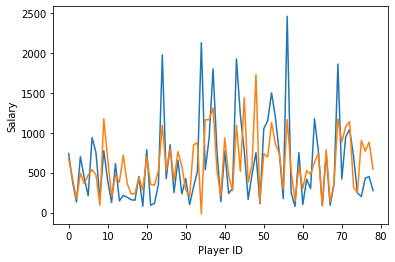

In [4]:
import matplotlib.pyplot as plt

# Make prediction usiing our model
prediction =  svr.predict(X_test_scaled)

# Our prediction are made from scaled data, so we need to "inverse the scaling" to find consistent data with the reality (salary's players)
prediction = y_scaler.inverse_transform(prediction)

# Plot our prediction (in orange) versus the truth (in blue)
plt.plot(y_test.T[0]) #Blue
plt.plot(prediction) #Orange
plt.xlabel('Player ID')
plt.ylabel('Salary')
plt.show()

In [5]:
from sklearn.metrics import mean_squared_error 

# Calculate the mean error between our prediction and the truth (represents by the y_test dataset)
accuracy = mean_squared_error(y_test.T[0], prediction, squared=False)
print("Mean Error:", accuracy)

Mean Error: 437.14115574476597


### Part 2: Feature Variance

Feature variance is a rather simple way of predicting if a given feature will have influence on the outcome of a trained model. The principle is that, if a feature has low variance, it cannot have much influence on the model prediction. As an extreme, if we have a variance of 0 in a feature across all samples, i.e. we have the same value for this feature in all samples, then this feature cannot be used to distinguish samples and is useless as a predictor.

However, the converse is not true. A high variance in a feature does not necessarily mean that it is a good predictor. You could imagine a feature that just contains noise with high amplitude. It might have high variance, but is meaningless. Or you can have a feature that has high variance but no influence on the outcome. For example, would hair length in cm have any influence on a baseball players salary? That said, variance can be a useful measure of the strength of a predictor.

The variance of a set of features is given by:

$$
S_{i}^{2} = \frac{\sum_{j=1}^n\left(\textbf{X}_{i,j} - \overline{\textbf{X}}_i \right)^2}{n - 1}
$$

where $\textbf{X}_{i,j}$ is the $j$'th sample of the $i$'th feature, $\overline{\textbf{X}}_i$ is the mean of all the samples of the $i$'th feature, and $n$ is the total number of samples.

Variance thresholding doesn't examine the relationship between the feature $\textbf{X}$ and the output $\textbf{y}$. This has the disadvantage that you can't test if the feature actually has an influence on the output. However, even though in this case we use it in a supervised learning context, it does mean that we can use variance thresholding for unsupervised learning.

#### Notes:
1. In Part 1, we used the StandardScaler to scale the features. In general, this is good practice, and in the next Task where we look at PCAs, really is even required. The `StandardScaler` will make it so every feature has a variance of 1 (unless the features started out with a variance of 0 to begin with) and a mean of 0. Therefore, features scaled with `StandardScaler` are useless for thresholding on variance, as there is no practical way to distinguish them.
2. However, we should not do `VarianceThreshold`ing on just the raw data. Have a look at the values in the training dataset. Some columns will have typically small value, such a `Years`, `HmRuns` and `Errors`. It is the nature of that data, and even though they may have a large influence on the salary of a player (see discussion at the end of this document), they will have a lower variance compared to some of the other columns.
3. So we must scale, but not using the `StandardScaler`. Here it is more appropriate to use the [`MinMaxScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), which scales all the data to the range 0 to 1 by default (though you can set any range).
4. Note that `MinMaxScaler` can also be applied to machine learning algorithms. Just in this case, we want to use the `StandardScaler`. There is, in fact, a [whole suite of other scalers provided by scikit-learn](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html). Each has it's own benefits. In fact, some would say we should use `MinMaxScaler` as the default scaler, and only use `StandardScaler` if we know the distribution of the data is normal.

#### Task:
1. Fit an instance of the `MinMaxScaler` with the original `X_train` data. You will get a set of data in the range 0 to 1.
2. It is not very intuitive what threshold of variance we should use. So it's better to plot the variances of each feature, and then decide if some of the variances are small enough to discard
3. Use `np.var` function to calculate the variances of the features (`axis-0`). Plot the variances, and pick a value that might remove 3 or 4 of the features.
4. Fit the output of the `MinMaxScaler` using an object of [`sklearn.feature_selection`'s `VarianceThreshold` class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html) using this threshold
5. `transform` the data that was scaled with the `StandardScaler`. This is an important step. Notice that we use the output of the `MinMaxScaler` to select the features, but the data we want to use is selected from the `StandardScaler`.
6. Repeat the steps of Part 1: Train an SVR with the selected features and print the `mean_square_error`.
7. How does the `mean_square_error` compare to the the SVR with no features removed (from Part 1)?

In [6]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Apply a Min Max scaling to the data
mm_scaler = MinMaxScaler()
mm_scaler.fit(X_train)
X_train_scaled_mm = mm_scaler.transform(X_train)

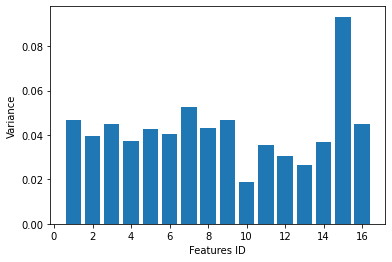

Variances details: 
[0.04685044 0.03940667 0.04509828 0.03750432 0.04286919 0.04054987
 0.05257365 0.04336473 0.04663321 0.01901254 0.03568655 0.03045842
 0.02645251 0.03664828 0.09329093 0.04506699]


In [7]:
# Calculate the variance of each features
variances = np.apply_along_axis(np.var, 0, X_train_scaled_mm)

# Get the number of features
lenght = variances.shape[0]

# Plot the variance of each feature
plt.bar(range(1,lenght + 1), variances)
plt.xlabel('Features ID')
plt.ylabel('Variance')
plt.show()
print("Variances details: ")
print(variances)

I decided to choose 0.036 as a variance threshold

In [8]:
from sklearn.feature_selection import VarianceThreshold

# I choose a threshold variance of 0.036 to remove 4 features (n°10, 11, 12 and 13)
selector = VarianceThreshold(0.036)

# Reduce data into 12 features
reduce_data = selector.fit_transform(X_train_scaled_mm)

In [9]:
from sklearn.preprocessing import StandardScaler

# Apply a standart scaling to the data
X_scaler2 = StandardScaler()
X_train_reduce_scaled = X_scaler2.fit_transform(reduce_data)

# Reshape the arrays into vector columns
y_train2 = y_train.reshape(-1, 1)
y_test2 = y_test.reshape(-1, 1)

# Apply a standart scaling to the data
y_scaler2 = StandardScaler()
y_scaler2.fit(y_train2)

y_train_scaled2 = y_scaler2.transform(y_train2)
y_test_scaled2 = y_scaler2.transform(y_test2)

In [10]:
from sklearn.svm import SVR

# Fit a SVR model with the train scaled data
svr2 = SVR(kernel='linear')
svr2.fit(X_train_reduce_scaled, y_train_scaled2.T[0])

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [11]:
# Apply the same Min Max scaling use for the train dataset, on the test dataset
X_test_scaled_mm = mm_scaler.transform(X_test)

# Reduce the test dataset in the same way (using the same object) that we reduced the train dataset
X_test_reduce = selector.transform(X_test_scaled_mm)

# Apply the same standart scaling use for the train dataset, on the test dataset
X_test_reduce_scaled = X_scaler2.fit_transform(X_test_reduce)

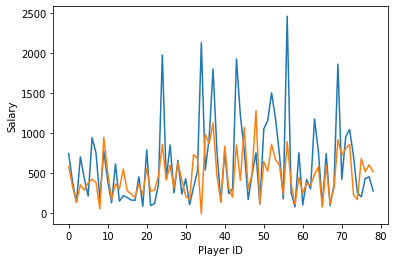

In [12]:
import matplotlib.pyplot as plt

# Make the prediction
prediction2 =  svr2.predict(X_test_reduce_scaled)

# Our prediction are made from scaled data, so we need to "inverse the scaling" to find consistent data with the reality (salary's players)
prediction2 = y_scaler2.inverse_transform(prediction2)

# Plot our prediction (in orange) versus the truth (in blue)
plt.plot(y_test2.T[0]) #Blue
plt.plot(prediction2) #Orange
plt.xlabel('Player ID')
plt.ylabel('Salary')
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error 

# Calculate the mean error between our prediction and the truth (represents by the y_test dataset)
accuracy2 = mean_squared_error(y_test2.T[0], prediction2, squared=False)
print("Mean Error:", accuracy2)

Mean Error: 452.9641747374698


### Part 3: Univariate Feature Selection - `f_regression`

Univariate feature selection works by performing statistical tests on each of the features (i.e. on each column in our dataset). There are a [few options provided by `scikit-learn`](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). We will use the [`SelectKBest` functionality](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html), which allows us to pick "the top" `K` features per the metric we select. To pick the top features, we will use the [`f_regression` function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html), as we are doing a regression. The `f_regression` calculates the correlation between the predictor $\textbf{X}^{(i)}$ and the target $\textbf{y}$, i.e.:

\begin{equation}
\sum_j\frac{\left(\textbf{X}^{(i)}_j - \overline{\textbf{X}}^{(i)}\right)\left(\textbf{y}_j - \overline{\textbf{y}}\right)}{\sigma_{\textbf{X}^{(i)}} \sigma_{\textbf{y}}}
\end{equation}

This is then converted to an F-score and a p-value. These are statistical terms that you may be familar with from a statistics course, but are not part of this module. An intuitive, but not rigourous, way of thinking of this is: this score measures how much influence a feature $\textbf{X}^{(i)}$ has on the outcome $\textbf{y}$.

The `SelectKBest` functionality coupled with `f_regression`, will use this score to pick the `K` top features.

#### Task:
1. Loop over the total count of features (i.e. for variable `k` from 1 to 16)
2. Use the [`SelectKBest` class](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) with [`f_regression`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html) to pick the top `k` features from our dataset
3. Train a new SVM regression with features transformed with the `SelectKBest` object you just created (note: both train and test data have to be transformed
4. Use the `mean_squared_error` function to get the RMSE at each iteration
5. Repeat steps 2 to 4 for each value of `k`.
6. Then plot the RMSE versus number of features in a single plot
7. Given this data, discuss the number of features you might use in a final solution? (Use markdown - no wrong answer here)
8. How doe the "best" RMSE value compare with the SVM before removing any features? 

In [14]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# Array to store the mean error per number of feature
mean_error_per_nb_of_feature = []
lenght = X_train.shape[1]

for k in range(1, lenght + 1):
  y_train3 = y_train.T[0]
  y_test3 = y_test.T[0]

  # Select the k best feature which influence the most our output
  selectKBest = SelectKBest(f_regression, k = k).fit(X_train, y_train3)

  # Apply the same selection on our test and train features
  X_train_selectKBest = selectKBest.transform(X_train)
  X_test_selectKBest = selectKBest.transform(X_test)

  # Fit a SVR model with the train scaled data
  svr3 = SVR(kernel='linear')
  svr3.fit(X_train_selectKBest, y_train3)

  # Make our prediction
  prediction3 = svr3.predict(X_test_selectKBest)

  # Calculate the mean error between our prediction and the truth (represents by the y_test dataset)
  accuracy3 = mean_squared_error(y_test3, prediction3, squared=False)
  print("k:", k, " -  Mean Error:", accuracy3)
  mean_error_per_nb_of_feature.append(accuracy3)

k: 1  -  Mean Error: 538.9668609529731
k: 2  -  Mean Error: 533.8959635870542
k: 3  -  Mean Error: 520.5263101613734
k: 4  -  Mean Error: 529.0184786856969
k: 5  -  Mean Error: 543.0354574446777
k: 6  -  Mean Error: 547.2216116071137
k: 7  -  Mean Error: 553.198910114379
k: 8  -  Mean Error: 476.5579528301648
k: 9  -  Mean Error: 464.2585807260495
k: 10  -  Mean Error: 478.75642142229896
k: 11  -  Mean Error: 464.2654606935016
k: 12  -  Mean Error: 469.3880069957863
k: 13  -  Mean Error: 469.65664503014807
k: 14  -  Mean Error: 456.2955408272489
k: 15  -  Mean Error: 459.8547136606153
k: 16  -  Mean Error: 447.1997859144394


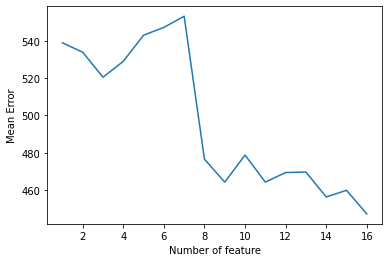

In [15]:
import matplotlib.pyplot as plt

# Pot the mean error versus the number of features kept
plt.plot(range(1,lenght + 1), mean_error_per_nb_of_feature)
plt.xlabel('Number of feature')
plt.ylabel('Mean Error')
plt.show()


7. Given this data, discuss the number of features you might use in a final solution?

We can see a big decrease in the mean error after selecting more than 7 features. Then it continues to deacrease (which logical because with more features, the model is more accurate) but less significantly.
I would chose 8 features in my final solution. With a big number of features, our model is more accurate but also slower. So I think 8 is a good tunning because it provides the best balance between low mean error and algorithm velocity.


8. How doe the "best" RMSE value compare with the SVM before removing any features?

The best RMSE value is found for 16 features with a value of 447\$. It is worse than in the first part, before removing any features where I found 437\$.

### An aside: Correlation and causation

It is worth taking a moment to consider the famous correlation vs causation problem in the context of the task we have just completed.

Have a look at the plot below.

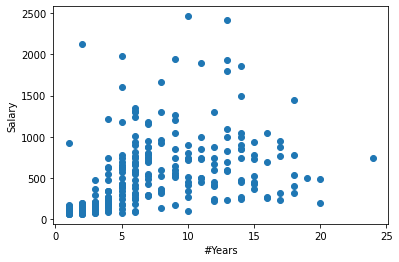

In [16]:
# given
import pandas as pd
df = pd.read_csv('Hitters_original.csv', header=0)
plt.scatter(df.iloc[:, 7], df.iloc[:, 19]);
plt.ylabel('Salary')
plt.xlabel('#Years')
plt.show()

There certainly seem to be some sort of correlation between the number of years playing and the salary that a player receives. It seems to increase (of course with outliers, as there are other influences), at least until 12 or 13 years in the game. Beyond that, the data is too sparse to really make a call, and maybe some players that are "past it" don't get a very high wage.

The fact that in our tasks above we chose `Years` as a feature does not mean, however, that the causal direction is from `Years` to `Salary`. That is, it does not mean that the number of years played actually causes a higher salary.There are, in fact, four options:
1. Number of years played *does* cause a higher salary. A hypothesis could be that the longer you play the game, the better you are at the game, and thus you get a higher salary
2. A higher salary causes a player to play for more years. A hypothesis could be that a player gets used to a nice, high salary, and then sticks around for longer on the high salary. Players on low salary are more likely to quit the game early.
3. An external influence causes both. A hypothesis could be that, good players enjoy fame. If you are famous, maybe you stick around for longer. And because you are famous, you make more money for your team in merchandise sales, so they pay you more money to make sure you stay with them, and not move to a competing team.
4. There is no causal relationship at all. The hypothesis is that all we are seeing is a statistical anomaly, and perhaps with more data we would realise that there is no relationship.

The point is, no machine learning model can infer causation. All supervised machine learning does is find correlations between a dataset of features and a corresponding set of ground truths. Whether a particular feature causes the output, or vice-versa, cannot be stated.

Feel free to discuss this type of topic in the forums.